# Load Dependencies and Check GPU Status

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np

# check if GPU is recognized
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Copyright 2019 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Defines routines to compute mel spectrogram features from audio waveform."""

import numpy as np


def frame(data, window_length, hop_length):
  """Convert array into a sequence of successive possibly overlapping frames.

  An n-dimensional array of shape (num_samples, ...) is converted into an
  (n+1)-D array of shape (num_frames, window_length, ...), where each frame
  starts hop_length points after the preceding one.

  This is accomplished using stride_tricks, so the original data is not
  copied.  However, there is no zero-padding, so any incomplete frames at the
  end are not included.

  Args:
    data: np.array of dimension N >= 1. (SIGNAL)
    window_length: Number of samples in each frame. (FRAME LENGTH)
    hop_length: Advance (in samples) between each window.   (NUMBER OF SAMPLES BETWEEN EACH FRAME)

  Returns:
    (N+1)-D np.array with as many rows as there are complete frames that can be
    extracted.
  """
  # frame(data, 1000, 16)
  # data can be 1 dimensional (mono) or 2 dimensional (stereo)
  # if data is 16000 samples long, window_len is 1000, stereo, then the shape would be (16, 1000, 2)
  # data.strides output: (num_channels * num_bytes, num_bytes) --> (8, 4)
  # data.stides[0]: num_channels in data
  # stides: (128, 8)
  num_samples = data.shape[0] # get length of signal (num samples)
  num_frames = 1 + int(np.floor((num_samples - window_length) / hop_length)) # frame count equation 
  shape = (num_frames, window_length) + data.shape[1:] # (number of frames, length of each frame), + num of channels(1 or 2)
  strides = (data.strides[0] * hop_length,) + data.strides # byte offset to move in each direction 
  return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides) # extract frames without copying


def periodic_hann(window_length):
  """Calculate a "periodic" Hann window.

  The classic Hann window is defined as a raised cosine that starts and
  ends on zero, and where every value appears twice, except the middle
  point for an odd-length window.  Matlab calls this a "symmetric" window
  and np.hanning() returns it.  However, for Fourier analysis, this
  actually represents just over one cycle of a period N-1 cosine, and
  thus is not compactly expressed on a length-N Fourier basis.  Instead,
  it's better to use a raised cosine that ends just before the final
  zero value - i.e. a complete cycle of a period-N cosine.  Matlab
  calls this a "periodic" window. This routine calculates it.

  Args:
    window_length: The number of points in the returned window.

  Returns:
    A 1D np.array containing the periodic hann window.
  """
  return 0.5 - (0.5 * np.cos(2 * np.pi / window_length *
                             np.arange(window_length)))


def stft_magnitude(signal, fft_length,
                   hop_length=None,
                   window_length=None):
  """Calculate the short-time Fourier transform magnitude.

  Args:
    signal: 1D np.array of the input time-domain signal.
    fft_length: Size of the FFT to apply.
    hop_length: Advance (in samples) between each frame passed to FFT.
    window_length: Length of each block of samples to pass to FFT.

  Returns:
    2D np.array where each row contains the magnitudes of the fft_length/2+1
    unique values of the FFT for the corresponding frame of input samples.
  """
  frames = frame(signal, window_length, hop_length)
  # Apply frame window to each frame. We use a periodic Hann (cosine of period
  # window_length) instead of the symmetric Hann of np.hanning (period
  # window_length-1).
  window = periodic_hann(window_length)
  windowed_frames = frames * window
  return np.abs(np.fft.rfft(windowed_frames, int(fft_length)))


# Mel spectrum constants and functions.
_MEL_BREAK_FREQUENCY_HERTZ = 700.0
_MEL_HIGH_FREQUENCY_Q = 1127.0


def hertz_to_mel(frequencies_hertz):
  """Convert frequencies to mel scale using HTK formula.

  Args:
    frequencies_hertz: Scalar or np.array of frequencies in hertz.

  Returns:
    Object of same size as frequencies_hertz containing corresponding values
    on the mel scale.
  """
  return _MEL_HIGH_FREQUENCY_Q * np.log(
      1.0 + (frequencies_hertz / _MEL_BREAK_FREQUENCY_HERTZ))


def spectrogram_to_mel_matrix(num_mel_bins=20,
                              num_spectrogram_bins=129,
                              audio_sample_rate=8000,
                              lower_edge_hertz=125.0,
                              upper_edge_hertz=3800.0):
  """Return a matrix that can post-multiply spectrogram rows to make mel.

  Returns a np.array matrix A that can be used to post-multiply a matrix S of
  spectrogram values (STFT magnitudes) arranged as frames x bins to generate a
  "mel spectrogram" M of frames x num_mel_bins.  M = S A.

  The classic HTK algorithm exploits the complementarity of adjacent mel bands
  to multiply each FFT bin by only one mel weight, then add it, with positive
  and negative signs, to the two adjacent mel bands to which that bin
  contributes.  Here, by expressing this operation as a matrix multiply, we go
  from num_fft multiplies per frame (plus around 2*num_fft adds) to around
  num_fft^2 multiplies and adds.  However, because these are all presumably
  accomplished in a single call to np.dot(), it's not clear which approach is
  faster in Python.  The matrix multiplication has the attraction of being more
  general and flexible, and much easier to read.

  Args:
    num_mel_bins: How many bands in the resulting mel spectrum.  This is
      the number of columns in the output matrix.
    num_spectrogram_bins: How many bins there are in the source spectrogram
      data, which is understood to be fft_size/2 + 1, i.e. the spectrogram
      only contains the nonredundant FFT bins.
    audio_sample_rate: Samples per second of the audio at the input to the
      spectrogram. We need this to figure out the actual frequencies for
      each spectrogram bin, which dictates how they are mapped into mel.
    lower_edge_hertz: Lower bound on the frequencies to be included in the mel
      spectrum.  This corresponds to the lower edge of the lowest triangular
      band.
    upper_edge_hertz: The desired top edge of the highest frequency band.

  Returns:
    An np.array with shape (num_spectrogram_bins, num_mel_bins).

  Raises:
    ValueError: if frequency edges are incorrectly ordered or out of range.
  """
  nyquist_hertz = audio_sample_rate / 2.
  if lower_edge_hertz < 0.0:
    raise ValueError("lower_edge_hertz %.1f must be >= 0" % lower_edge_hertz)
  if lower_edge_hertz >= upper_edge_hertz:
    raise ValueError("lower_edge_hertz %.1f >= upper_edge_hertz %.1f" %
                     (lower_edge_hertz, upper_edge_hertz))
  if upper_edge_hertz > nyquist_hertz:
    raise ValueError("upper_edge_hertz %.1f is greater than Nyquist %.1f" %
                     (upper_edge_hertz, nyquist_hertz))
  spectrogram_bins_hertz = np.linspace(0.0, nyquist_hertz, num_spectrogram_bins)
  spectrogram_bins_mel = hertz_to_mel(spectrogram_bins_hertz)
  # The i'th mel band (starting from i=1) has center frequency
  # band_edges_mel[i], lower edge band_edges_mel[i-1], and higher edge
  # band_edges_mel[i+1].  Thus, we need num_mel_bins + 2 values in
  # the band_edges_mel arrays.
  band_edges_mel = np.linspace(hertz_to_mel(lower_edge_hertz),
                               hertz_to_mel(upper_edge_hertz), num_mel_bins + 2)
  # Matrix to post-multiply feature arrays whose rows are num_spectrogram_bins
  # of spectrogram values.
  mel_weights_matrix = np.empty((num_spectrogram_bins, num_mel_bins))
  for i in range(num_mel_bins):
    lower_edge_mel, center_mel, upper_edge_mel = band_edges_mel[i:i + 3]
    # Calculate lower and upper slopes for every spectrogram bin.
    # Line segments are linear in the *mel* domain, not hertz.
    lower_slope = ((spectrogram_bins_mel - lower_edge_mel) /
                   (center_mel - lower_edge_mel))
    upper_slope = ((upper_edge_mel - spectrogram_bins_mel) /
                   (upper_edge_mel - center_mel))
    # .. then intersect them with each other and zero.
    mel_weights_matrix[:, i] = np.maximum(0.0, np.minimum(lower_slope,
                                                          upper_slope))
  # HTK excludes the spectrogram DC bin; make sure it always gets a zero
  # coefficient.
  mel_weights_matrix[0, :] = 0.0
  return mel_weights_matrix


def log_mel_spectrogram(data,
                        audio_sample_rate=8000,
                        log_offset=0.0,
                        window_length_secs=0.025,
                        hop_length_secs=0.010,
                        **kwargs):
  """Convert waveform to a log magnitude mel-frequency spectrogram.

  Args:
    data: 1D np.array of waveform data.
    audio_sample_rate: The sampling rate of data.
    log_offset: Add this to values when taking log to avoid -Infs.
    window_length_secs: Duration of each window to analyze.
    hop_length_secs: Advance between successive analysis windows.
    **kwargs: Additional arguments to pass to spectrogram_to_mel_matrix.

  Returns:
    2D np.array of (num_frames, num_mel_bins) consisting of log mel filterbank
    magnitudes for successive frames.
  """
  window_length_samples = int(round(audio_sample_rate * window_length_secs))
  hop_length_samples = int(round(audio_sample_rate * hop_length_secs))
  fft_length = 2 ** int(np.ceil(np.log(window_length_samples) / np.log(2.0)))
  spectrogram = stft_magnitude(
      data,
      fft_length=fft_length,
      hop_length=hop_length_samples,
      window_length=window_length_samples)
  mel_spectrogram = np.dot(spectrogram, spectrogram_to_mel_matrix(
      num_spectrogram_bins=spectrogram.shape[1],
      audio_sample_rate=audio_sample_rate, **kwargs))
  return np.log(mel_spectrogram + log_offset)


# Create TensorFlow Dataset

In [4]:
# define paths to positive and negative data
NOT_BAD = os.path.join("C:/Users/jreye/ML_DATA/NotBadWords/NotBad_comp") 
FUCK = os.path.join("C:/Users/jreye/ML_DATA/BadWords/fuck_comp_all_44k") 
SHIT = os.path.join("C:/Users/jreye/ML_DATA/BadWords/shit_comp_all") 

# Create multi-classification datasets
not_bad = tf.data.Dataset.list_files(NOT_BAD+'\*.wav').map(lambda x: (x, tf.constant([1, 0, 0], dtype=tf.float32))) 
fuck = tf.data.Dataset.list_files(FUCK+'\*.wav').map(lambda x: (x, tf.constant([0, 1, 0], dtype=tf.float32))) 
shit = tf.data.Dataset.list_files(SHIT+'\*.wav').map(lambda x: (x, tf.constant([0, 0, 1], dtype=tf.float32))) 

data = not_bad.concatenate(fuck)
data = data.concatenate(shit)

print("Size of not_bad dataset: " + repr(len(not_bad)))
print("Size of fuck dataset   : " + repr(len(fuck)))
print("Size of shit dataset   : " + repr(len(shit)))

bufferSize = len(not_bad) + len(fuck) + len(shit)

# for debugging
#list(fuck.as_numpy_iterator())

Size of not_bad dataset: 1850
Size of fuck dataset   : 1438
Size of shit dataset   : 1236


# Build Preprocessing Function to Convert to Spectrogram

In [8]:
def load_wav(file_path):
    file_contents = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    # Convert to mono if the audio has more than one channel
    if audio.shape[-1] > 1:
        audio = tf.reduce_mean(audio, axis=-1, keepdims=True)
        
    audio = tf.squeeze(audio, axis=-1) # remove trailing axis
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    audio = tfio.audio.resample(audio, rate_in=sample_rate, rate_out=16000)
    return audio








def pad_spectrogram(spectrogram, target_shape):
    # Calculate the required padding
    padding = [[0, target_shape[0] - spectrogram.shape[0]], [0, 0]]
    
    # Apply the padding
    padded_spectrogram = tf.pad(spectrogram, padding, mode='CONSTANT', constant_values=0)
    
    return padded_spectrogram

In [13]:
def preprocess(file_path, label):
    # WORKING CODE
    audio = load_wav(file_path)

    # Parameters for the mel spectrogram
    sample_rate = 16000
    num_mel_bins = 32
    lower_edge_hertz = 60.0
    upper_edge_hertz = 3800.0
    window_length_secs = 0.025
    hop_length_secs = 0.010
    log_offset = 0.001

    # Convert the audio tensor to a NumPy array
    audio_np = audio.numpy()

    # Compute the log mel spectrogram
    test_spectrogram = 30 * log_mel_spectrogram(
        audio_np,
        audio_sample_rate=sample_rate,
        log_offset=log_offset,
        window_length_secs=window_length_secs,
        hop_length_secs=hop_length_secs,
        num_mel_bins=num_mel_bins,
        lower_edge_hertz=lower_edge_hertz,
        upper_edge_hertz=upper_edge_hertz) - np.log(1e-3)
    
    test_spectrogram = tf.cast(test_spectrogram, tf.float32)  # Cast to float32
    
    test_spectrogram = np.clip(test_spectrogram, 0, 255).astype(np.uint8)

    # Normalize the spectrogram per frequency bin (column-wise)
    test_spectrogram = test_spectrogram.astype(np.float32)  # Convert back to float32 for calculations
    test_spectrogram -= np.mean(test_spectrogram, axis=0)
    epsilon = 1e-8  # Small constant to avoid division by zero
    test_spectrogram /= (np.std(test_spectrogram, axis=0) + epsilon)
    test_spectrogram += 1
    test_spectrogram *= 127.5

    # Clip the spectrogram back to the uint8 range
    test_spectrogram = np.clip(test_spectrogram, 0, 255).astype(np.uint8)
    target_shape = (198, 32)

    # Pad the spectrogram
    padded_spectrogram = pad_spectrogram(test_spectrogram, target_shape)

    return padded_spectrogram, label

def preprocess0(file_path, label):
    # WORKING CODE
    audio = load_wav(file_path)

    # Parameters for the mel spectrogram
    sample_rate = 16000
    num_mel_bins = 32
    lower_edge_hertz = 60.0
    upper_edge_hertz = 3800.0
    window_length_secs = 0.025
    hop_length_secs = 0.010
    log_offset = 0.001

    # Convert the audio tensor to a NumPy array
    audio_np = audio.numpy()

    # Compute the log mel spectrogram
    test_spectrogram = 30 * log_mel_spectrogram(
        audio_np,
        audio_sample_rate=sample_rate,
        log_offset=log_offset,
        window_length_secs=window_length_secs,
        hop_length_secs=hop_length_secs,
        num_mel_bins=num_mel_bins,
        lower_edge_hertz=lower_edge_hertz,
        upper_edge_hertz=upper_edge_hertz) - np.log(1e-3)
    
    test_spectrogram = tf.cast(test_spectrogram, tf.float32)  # Cast to float32
    
    target_shape = (198, 32)

    # Pad the spectrogram
    padded_spectrogram = pad_spectrogram(test_spectrogram, target_shape)

    return padded_spectrogram, label


Selected file: C:\Users\jreye\ML_DATA\BadWords\fuck_comp_all_44k\whiteNoise_0_2_Recording #244.wav
(198, 32)
[0. 1. 0.]


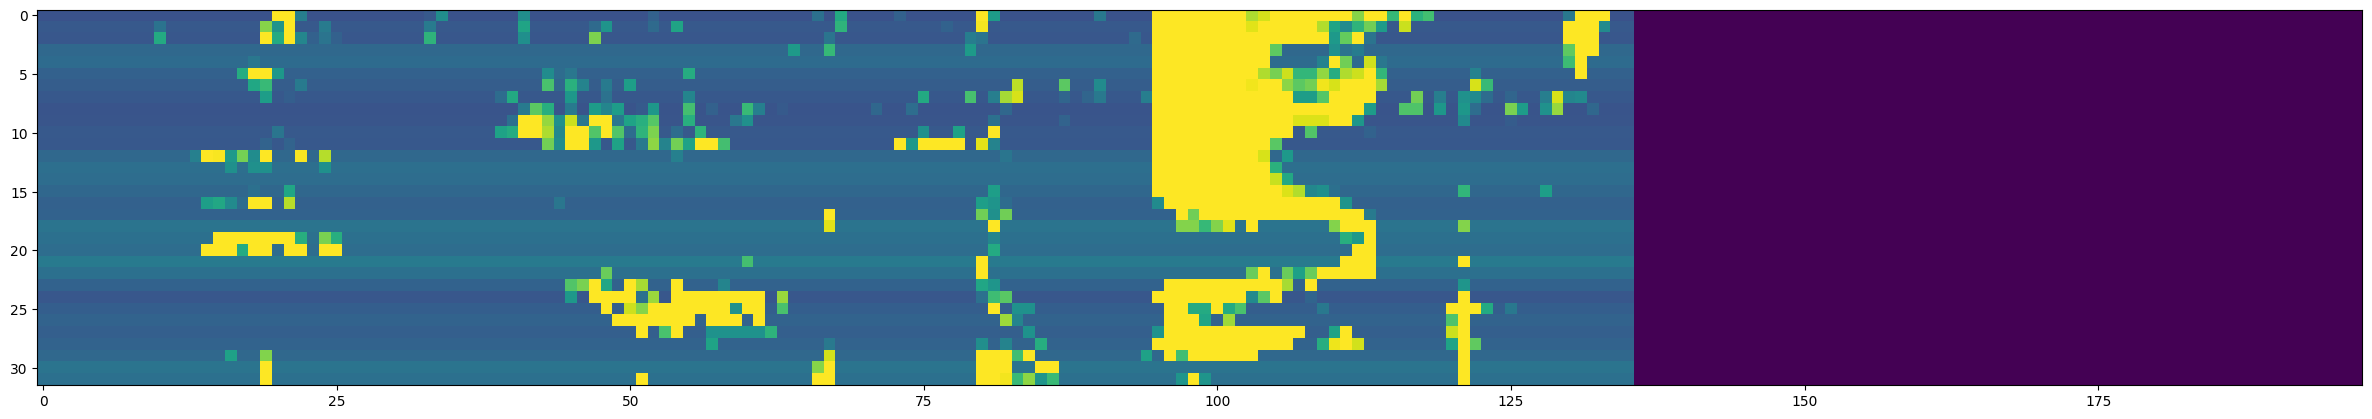

Selected file: C:\Users\jreye\ML_DATA\BadWords\fuck_comp_all_44k\whiteNoise_0_2_Recording #244.wav
(198, 32)
[0. 1. 0.]


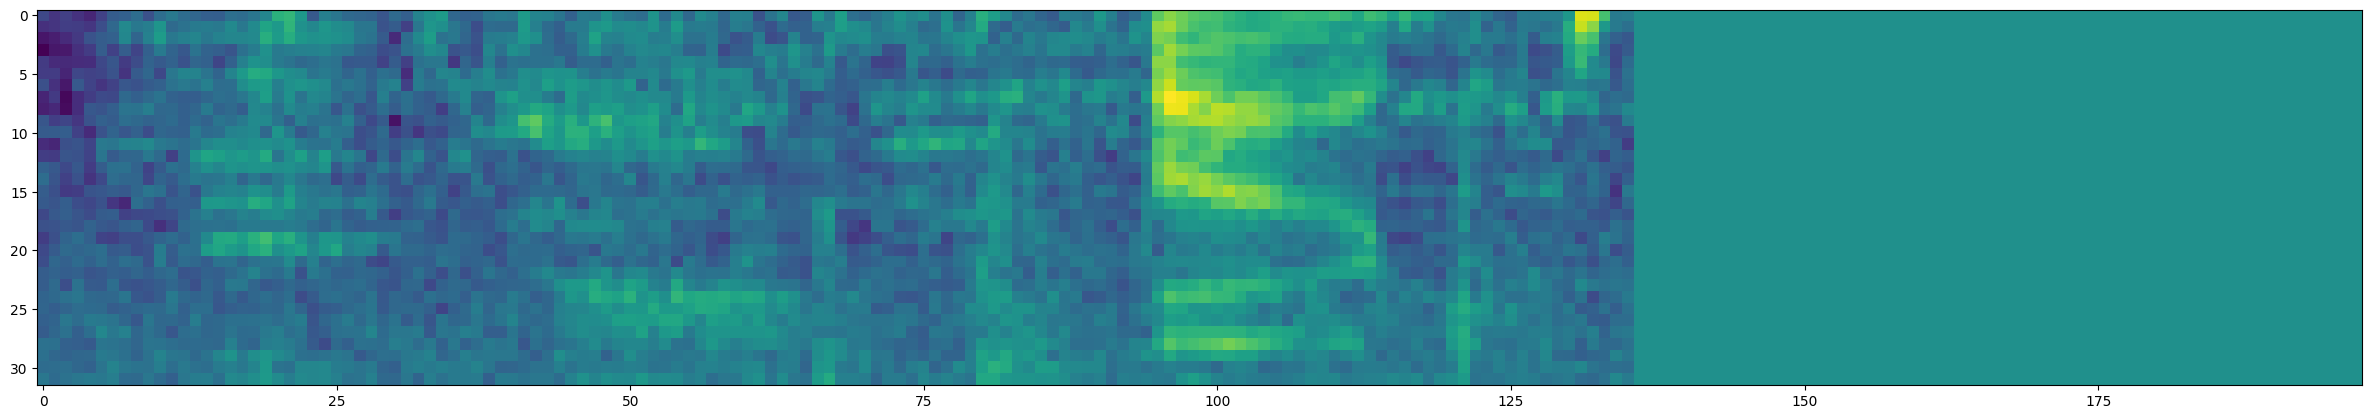

In [14]:
filepath, label = data.shuffle(buffer_size=10000).as_numpy_iterator().next()
padded_spectrogram, label = preprocess(filepath, label)

# Convert the filepath tensor to a string
filename_str = filepath.decode('utf-8')

# Print the file name
print(f"Selected file: {filename_str}")

print(padded_spectrogram.shape)
print(label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(padded_spectrogram))
plt.show() 

padded_spectrogram, label = preprocess0(filepath, label)

# Convert the filepath tensor to a string
filename_str = filepath.decode('utf-8')

# Print the file name
print(f"Selected file: {filename_str}")

print(padded_spectrogram.shape)
print(label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(padded_spectrogram))
plt.show() 

# Create Training and Testing Partitions

In [15]:
len(data)

4524

In [16]:
def preprocess_py_function(file_path, label):
    file_path, label = tf.py_function(preprocess, [file_path, label], [tf.uint8, tf.float32])
    file_path.set_shape((198, 32))
    file_path = tf.cast(file_path, tf.uint8)  # Cast to float32
    label.set_shape((3,))  # Set shape to (3,)

    spectrogram_expanded = file_path  # Remove the extra dimension
    label_expanded = label  # Remove the extra dimension

    return spectrogram_expanded, label_expanded




data = data.map(preprocess_py_function)
data = data.cache()
data = data.shuffle(buffer_size=bufferSize - 12)
data = data.batch(16)
data = data.prefetch(16)

In [17]:
len(data)

283

In [18]:
train_size = round(len(data) * 0.7)
print(train_size)

198


In [19]:
test_size = round(len(data) - len(data)*.7)
print(test_size)

85


In [20]:
# split into training and testing partitions
train = data.take(train_size) # 70 % goes to train set
test = data.skip(train_size).take(test_size) # 30 % goes to test set

In [21]:
# test one batch
samples, labels = train.as_numpy_iterator().next()

In [22]:
samples.shape

(16, 198, 32)

In [23]:
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [24]:
def extract_data_labels(dataset):
    data_list, labels_list = [], []
    for data, labels in dataset.as_numpy_iterator():
        data_list.append(data)
        labels_list.append(labels)
    data = np.concatenate(data_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return data, labels

X_train, y_train = extract_data_labels(train)
X_test, y_test = extract_data_labels(test)



In [25]:
X_train.shape

(3168, 198, 32)

In [26]:
y_train.shape

(3168, 3)

# Train Various Configurations of Model Using Keras-Tuner

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from kerastuner import RandomSearch

def create_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(198, 32)))
    
    # Variable number of Dense layers
    for i in range(hp.Int('num_layers', 1, 2)):  # Reduced the range to around the best value
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=128, max_value=288, step=32), activation='relu'))  # Adjusted the range around the best value
        model.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.05, max_value=0.15, step=0.05)))  # Adjusted the range around the best value
    
    model.add(Dense(3, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[5e-5])),  # Adjusted the values around the best value
        loss='categorical_crossentropy',
        metrics=[Precision(name='precision'), Recall(name='recall'), CategoricalAccuracy(name='categorical_accuracy')]
    )

    return model

from kerastuner.tuners import BayesianOptimization

tuner = BayesianOptimization(
    create_model,
    objective='val_categorical_accuracy',
    max_trials=25,  # Increase the number of trials here
    executions_per_trial=3,
    directory='keras_tuner_output',
    project_name='BadMouth_FNN_10_new3'
)

tuner.search_space_summary()

# Replace X_train, y_train, X_val, and y_val with your own data
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=16)

best_hyperparameters = tuner.get_best_hyperparameters()[0]

optimized_model = create_model(best_hyperparameters)
optimized_model.summary()


Trial 25 Complete [00h 00m 28s]
val_categorical_accuracy: 0.9680432677268982

Best val_categorical_accuracy So Far: 0.9793510437011719
Total elapsed time: 00h 11m 58s
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 6336)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               1622272   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,623,043
Trainable params: 1,623,043
Non-trainable params: 0
_____________________________________

In [29]:
# Print the best hyperparameters
print("Best hyperparameters:")
for hp, value in best_hyperparameters.get_config()['values'].items():
    print(f"{hp}: {value}")

# Print the input shape of the optimized model
input_shape = optimized_model.layers[0].input_shape
print("Input shape of the optimized model:", input_shape)


Best hyperparameters:
num_layers: 1
units_0: 256
dropout_0: 0.05
learning_rate: 5e-05
units_1: 192
dropout_1: 0.05
Input shape of the optimized model: (None, 198, 32)


In [30]:
history = optimized_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=16)

Epoch 1/10
198/198 [==============================] - 1s 5ms/step - loss: 14.1453 - precision: 0.7696 - recall: 0.7696 - categorical_accuracy: 0.7696 - val_loss: 3.5718 - val_precision: 0.9086 - val_recall: 0.9086 - val_categorical_accuracy: 0.9086
Epoch 2/10
198/198 [==============================] - 1s 4ms/step - loss: 4.2530 - precision: 0.9028 - recall: 0.9028 - categorical_accuracy: 0.9028 - val_loss: 1.6703 - val_precision: 0.9417 - val_recall: 0.9417 - val_categorical_accuracy: 0.9417
Epoch 3/10
198/198 [==============================] - 1s 4ms/step - loss: 2.7862 - precision: 0.9085 - recall: 0.9085 - categorical_accuracy: 0.9085 - val_loss: 1.7701 - val_precision: 0.9417 - val_recall: 0.9417 - val_categorical_accuracy: 0.9417
Epoch 4/10
198/198 [==============================] - 1s 4ms/step - loss: 1.3468 - precision: 0.9397 - recall: 0.9397 - categorical_accuracy: 0.9397 - val_loss: 1.0780 - val_precision: 0.9535 - val_recall: 0.9535 - val_categorical_accuracy: 0.9535
Epoch 5

# Compile Best Model and Evaluate

In [31]:
optimized_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Recall(), Precision(), CategoricalAccuracy()])
optimized_model.evaluate(X_test, y_test)

43/43 [==============================] - 0s 3ms/step - loss: 0.4962 - recall: 0.9720 - precision: 0.9720 - categorical_accuracy: 0.9720


[0.4962487816810608,
 0.9719763994216919,
 0.9719763994216919,
 0.9719763994216919]

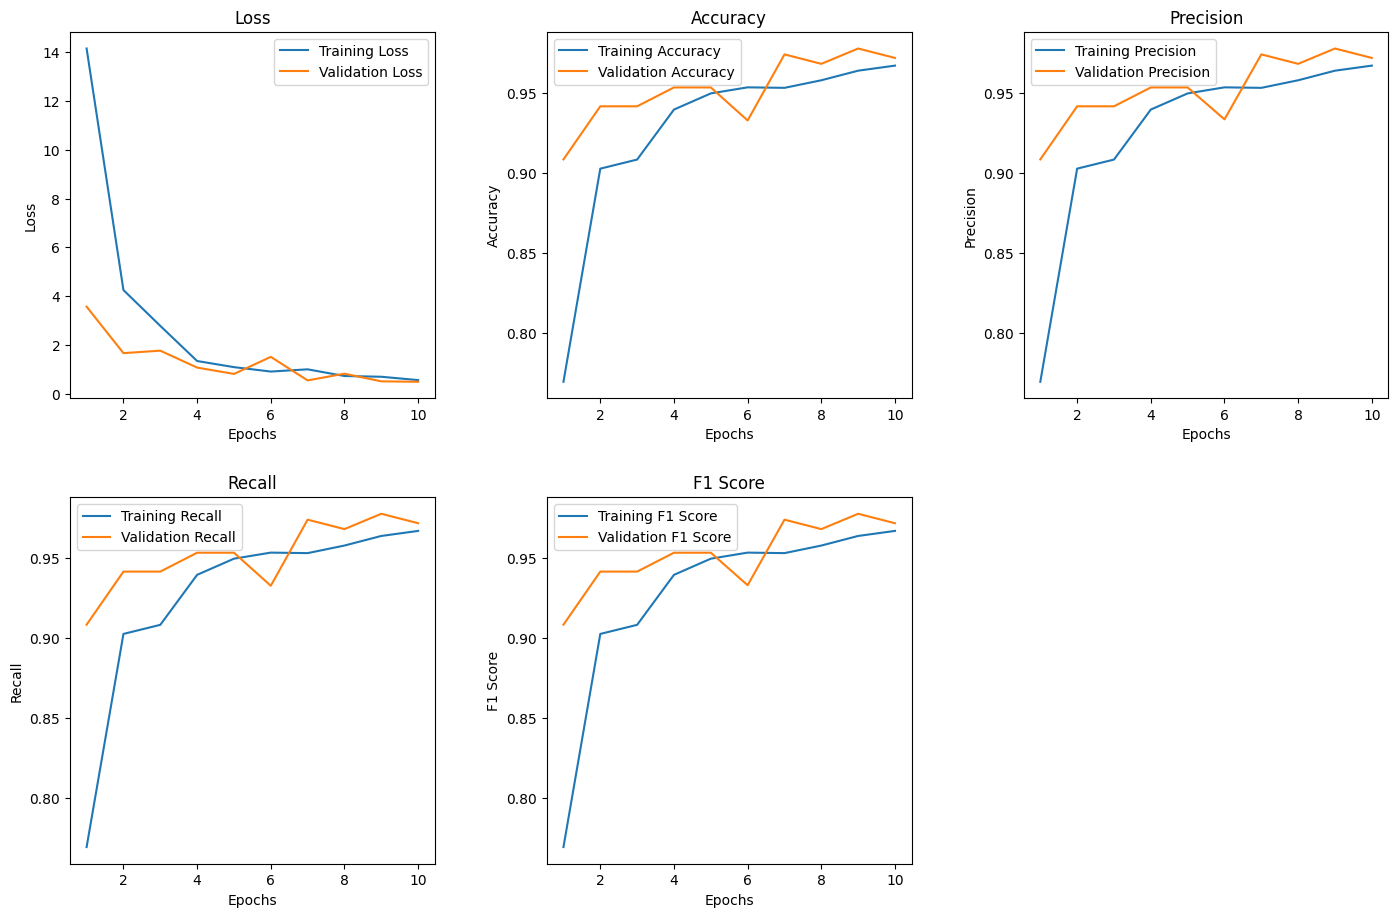

In [32]:
history_f1 = [2 * (precision * recall) / (precision + recall) for precision, recall in zip(history.history['precision'], history.history['recall'])]
val_history_f1 = [2 * (precision * recall) / (precision + recall) for precision, recall in zip(history.history['val_precision'], history.history['val_recall'])]

epochs = range(1, len(history.history['loss']) + 1)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.tight_layout(pad=5.0)

# Loss
axes[0, 0].plot(epochs, history.history['loss'], label='Training Loss')
axes[0, 0].plot(epochs, history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Loss')

# Accuracy
axes[0, 1].plot(epochs, history.history['categorical_accuracy'], label='Training Accuracy')
axes[0, 1].plot(epochs, history.history['val_categorical_accuracy'], label='Validation Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].set_title('Accuracy')

# Precision
axes[0, 2].plot(epochs, history.history['precision'], label='Training Precision')
axes[0, 2].plot(epochs, history.history['val_precision'], label='Validation Precision')
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()
axes[0, 2].set_title('Precision')

# Recall
axes[1, 0].plot(epochs, history.history['recall'], label='Training Recall')
axes[1, 0].plot(epochs, history.history['val_recall'], label='Validation Recall')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].set_title('Recall')

# F1 Score
axes[1, 1].plot(epochs, history_f1, label='Training F1 Score')
axes[1, 1].plot(epochs, val_history_f1, label='Validation F1 Score')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].legend()
axes[1, 1].set_title('F1 Score')

# Remove the empty subplot
fig.delaxes(axes[1, 2])

plt.show()


In [43]:
# get one batch and make a prediction
X_test, y_test = test.as_numpy_iterator().next()
print(X_test.shape)
yhat = optimized_model.predict(X_test)

# Convert logits to classes
y_pred = np.argmax(yhat, axis=1)
y_pred

# Convert true labels to class indices
y_test_indices = np.argmax(y_test, axis=1)

(16, 198, 32)
1/1 [==============================] - 0s 15ms/step


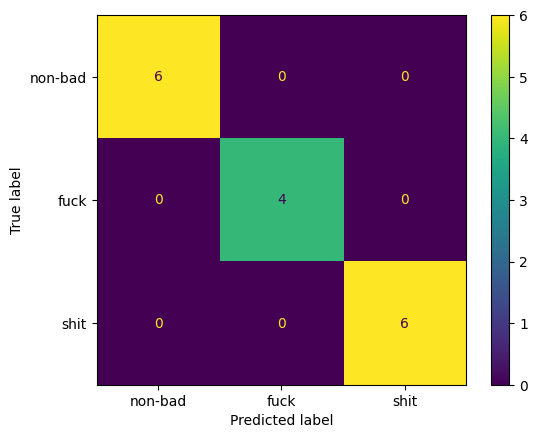

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_indices, y_pred)

# Use the class names as display labels
class_names = ['non-bad', 'fuck', 'shit']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

In [45]:
optimized_model.save_weights("MEL_FNN_non_fixed_v5.h5")

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

def create_fixed_model():
    input_layer = Input(shape=(198, 32), batch_size=1)
    x = Flatten()(input_layer)

    x = Dense(units=256, activation='relu')(x)
    x = Dropout(rate=0.05)(x)

    output_layer = Dense(3, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(
        optimizer=Adam(learning_rate=5e-05),
        loss='categorical_crossentropy',
        metrics=[Precision(name='precision'), Recall(name='recall'), CategoricalAccuracy(name='categorical_accuracy')]
    )

    return model



# Create the fixed model
fixed_model = create_fixed_model()
fixed_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 198, 32)]            0         
                                                                 
 flatten_2 (Flatten)         (1, 6336)                 0         
                                                                 
 dense_4 (Dense)             (1, 256)                  1622272   
                                                                 
 dropout_2 (Dropout)         (1, 256)                  0         
                                                                 
 dense_5 (Dense)             (1, 3)                    771       
                                                                 
Total params: 1,623,043
Trainable params: 1,623,043
Non-trainable params: 0
_________________________________________________________________


In [47]:
fixed_model.set_weights(optimized_model.get_weights())

In [48]:
input_shape = fixed_model.layers[0].input_shape
output_shape = fixed_model.layers[-1].output_shape

print("Input shape:", input_shape)
print("Output shape:", output_shape)

Input shape: [(1, 198, 32)]
Output shape: (1, 3)


In [47]:
fixed_model.save("MEL_FNN_fixed_V5.h5")

# Convert to TF Lite (8-bit Quantized)

### Create Representative Dataset

In [48]:
import random

def representative_dataset_gen():
    preprocessed_data = list(data.as_numpy_iterator())
    inputs = np.concatenate([sample[0] for sample in preprocessed_data], axis=0)
    labels = np.concatenate([sample[1] for sample in preprocessed_data], axis=0)

    sample_indices = np.random.choice(inputs.shape[0], size=100, replace=False)
    representative_samples = inputs[sample_indices]

    for sample in representative_samples:
        # Normalize the input to the range [0, 1]
        sample = sample / 255.0 # might need to change normalization method (not use dynamic range compression)

        # Reshape the input to the required format
        sample = np.expand_dims(sample, axis=0).astype(np.float32)

        yield [sample]


### Convert to TFLite

In [49]:
# Load the Keras model
loaded_model = tf.keras.models.load_model('MEL_FNN_fixed_V5.h5')

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quantized_model = converter.convert()

# Save the TensorFlow Lite model
with open('MEL_FNN_fixed_V5_quantized.tflite', 'wb') as f:
    f.write(tflite_quantized_model)

    
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File Size: ' + str(round(size /1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File Size: ' + str(round(size /(1024*1024), 3)) + ' Megabytes')
    else:
        return print('File Size: ' + str(size) + 'bytes')

INFO:tensorflow:Assets written to: C:\Users\jreye\AppData\Local\Temp\tmph79qs_p5\assets


C:\Users\jreye\anaconda3\envs\test_GPU\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [50]:
# check input tensor shape
convert_bytes(get_file_size("MEL_FNN_fixed_V5_quantized.tflite"), "MB")

File Size: 1.549 Megabytes
